## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

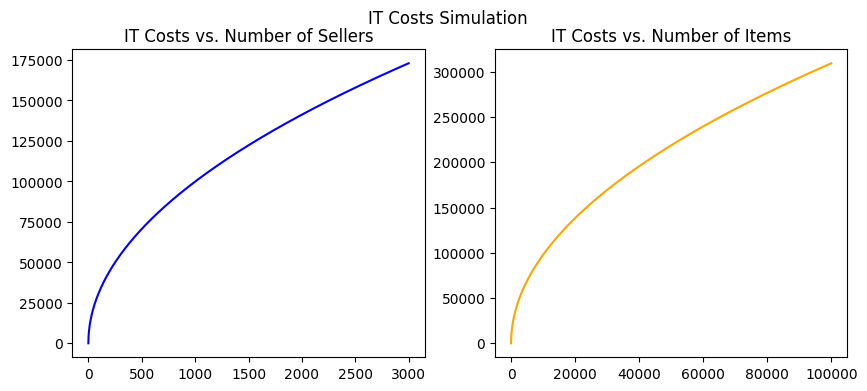

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

In [2]:
import olist.seller
print(olist.seller.__file__)

/Users/berkayturhan/data-context-and-setup/olist/seller.py


In [3]:
from olist.seller import Seller
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_score,cost_of_reviews,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.0,0.333333,0.333333,3.00,140.0,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.0,0.025000,0.725000,4.55,246.0,2290.307,2044.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,0.000000,0.0,0.000000,1.000000,5.00,0.0,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,0.000000,0.0,0.000000,1.000000,5.00,0.0,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.0,0.000000,0.000000,1.00,100.0,16.799,-83.201


### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

In [4]:
# 1. Satıcıları Kârına göre (Çoktan aza) sırala ve index'i sıfırla
sorted_sellers = sellers.sort_values(by='profits', ascending=False).reset_index(drop=True)

# İlk 5'e bakalım (Yıldızlar karması)
sorted_sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_two_stars,share_of_three_stars,share_of_five_stars,review_score,cost_of_reviews,revenues,profits
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,1.145251,222776.05,0.095506,0.025281,0.092697,0.561798,4.132022,5954.213483,23237.605,17283.391517
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,0.101493,0.017910,0.074627,0.629851,4.214925,4770.149254,19323.187,14553.037746
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,0.086059,0.018933,0.041308,0.676420,4.339071,6566.024096,21004.203,14438.178904
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,166,175,1.054217,79284.55,0.066265,0.012048,0.048193,0.692771,4.421687,1602.409639,8808.455,7206.045361
4,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,521,542,1.040307,128111.19,0.112621,0.019417,0.058252,0.629126,4.194175,7893.203883,14651.119,6757.915117


In [5]:
# 2. Her satır için birikimli (kümülatif) değerleri hesapla
sorted_sellers['cum_profits'] = sorted_sellers['profits'].cumsum()
sorted_sellers['cum_revenues'] = sorted_sellers['revenues'].cumsum()
sorted_sellers['cum_quantity'] = sorted_sellers['quantity'].cumsum()

# Sonuçları görelim
sorted_sellers[['profits', 'cum_profits']].head()

,profits,cum_profits
0,17283.391517,17283.391517
1,14553.037746,31836.429263
2,14438.178904,46274.608167
3,7206.045361,53480.653528
4,6757.915117,60238.568645


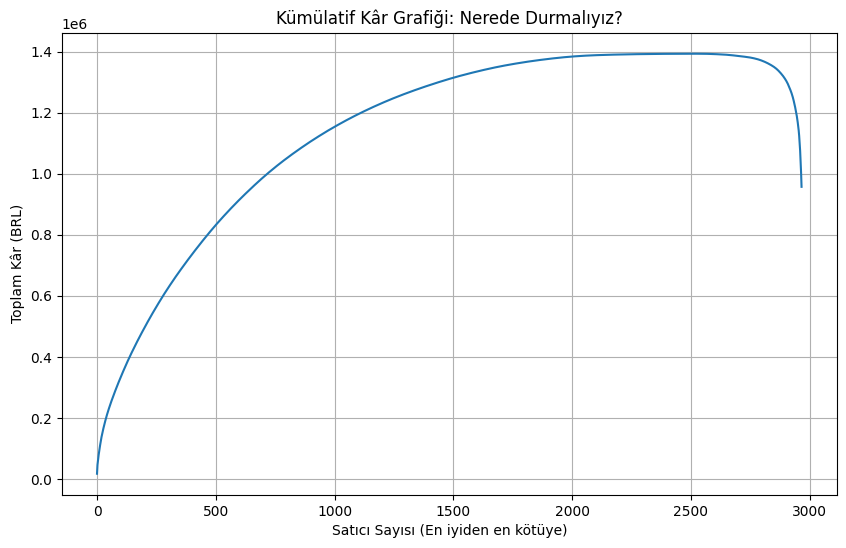

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sorted_sellers['cum_profits'].plot()
plt.title("Kümülatif Kâr Grafiği: Nerede Durmalıyız?")
plt.xlabel("Satıcı Sayısı (En iyiden en kötüye)")
plt.ylabel("Toplam Kâr (BRL)")
plt.grid(True)
plt.show()

In [7]:
import numpy as np

# En yüksek kârın olduğu index'i bul (argmax)
idx_max = sorted_sellers['cum_profits'].argmax()

# Kaç satıcı tutmalıyız? (Index 0'dan başladığı için +1 ekliyoruz)
optimum_seller_count = idx_max + 1

print(f"--- SONUÇLAR ---")
print(f"Optimum Satıcı Sayısı: {optimum_seller_count}")
print(f"Maksimum Kâr (IT Masrafı Hariç): {sorted_sellers['cum_profits'].iloc[idx_max]:,.2f} BRL")
print(f"Bu noktadaki Toplam Gelir: {sorted_sellers['cum_revenues'].iloc[idx_max]:,.2f} BRL")
print(f"Satılan Toplam Ürün Adedi: {sorted_sellers['cum_quantity'].iloc[idx_max]:,.0f}")

--- SONUÇLAR ---
Optimum Satıcı Sayısı: 2523
Maksimum Kâr (IT Masrafı Hariç): 1,393,186.54 BRL
Bu noktadaki Toplam Gelir: 2,243,417.69 BRL
Satılan Toplam Ürün Adedi: 62,637


### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


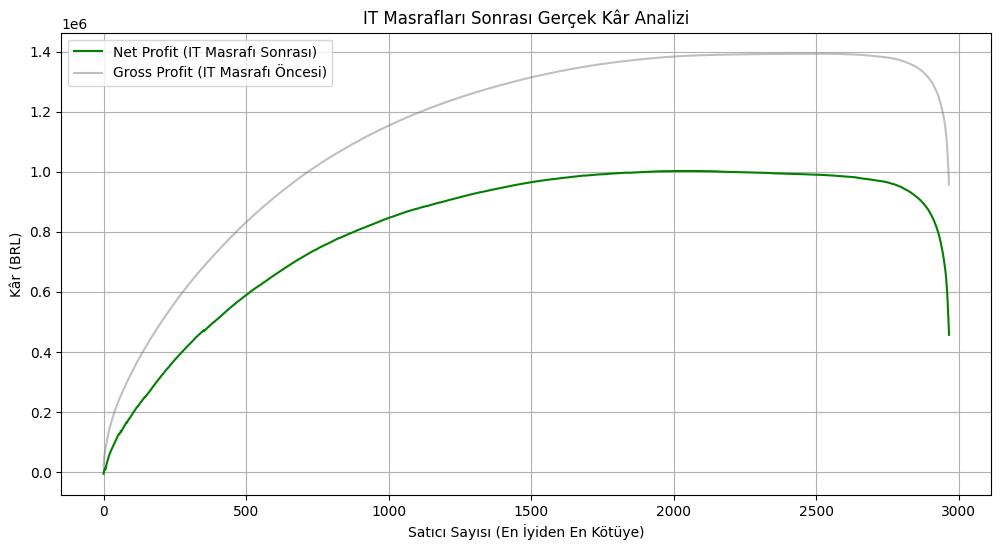

--- FİNAL RAPORU ---
Optimum Satıcı Sayısı: 2055
Net Kâr (IT Sonrası): 1,002,770.79 BRL
IT Maliyeti: 383,949.16 BRL


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Sabit Değerler (Data Team'den gelen katsayılar)
alpha = 3157.27
beta = 978.23

# 2. IT Cost Hesaplayan Fonksiyon
def calculate_it_costs(n_sellers, n_items):
    # Formül: alpha * kök(satıcı_sayısı) + beta * kök(ürün_sayısı)
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

# 3. Verileri Hazırlama (Sıralama ve Kümülatifler)
# Satıcıları yine en çok kâr ettirenden en aza doğru diziyoruz
sorted_sellers = sellers.sort_values(by='profits', ascending=False).reset_index(drop=True)

# Kümülatif (Birikimli) Toplamlar
sorted_sellers['cum_profits'] = sorted_sellers['profits'].cumsum()
sorted_sellers['cum_quantity'] = sorted_sellers['quantity'].cumsum()

# Satıcı sayısını (1, 2, 3...) bir sütun olarak ekleyelim (index 0'dan başladığı için +1 ekliyoruz)
sorted_sellers['n_sellers'] = np.arange(1, len(sorted_sellers) + 1)

# 4. IT Maliyetlerini ve Net Kârı Hesapla
# Her satır için o anki satıcı sayısı ve toplam ürün sayısına göre maliyet çıkarıyoruz
sorted_sellers['it_costs'] = calculate_it_costs(sorted_sellers['n_sellers'], sorted_sellers['cum_quantity'])

# Net Kâr = (Brüt Kâr) - (IT Masrafı)
sorted_sellers['net_profits'] = sorted_sellers['cum_profits'] - sorted_sellers['it_costs']

# 5. Grafiği Çizelim 📈
plt.figure(figsize=(12,6))
plt.plot(sorted_sellers['net_profits'], label='Net Profit (IT Masrafı Sonrası)', color='green')
plt.plot(sorted_sellers['cum_profits'], label='Gross Profit (IT Masrafı Öncesi)', color='grey', alpha=0.5)
plt.title("IT Masrafları Sonrası Gerçek Kâr Analizi")
plt.xlabel("Satıcı Sayısı (En İyiden En Kötüye)")
plt.ylabel("Kâr (BRL)")
plt.legend()
plt.grid(True)
plt.show()

# 6. Sonucu Bulalım (Optimum Nokta)
idx_opt = sorted_sellers['net_profits'].argmax()
optimum_seller_count = idx_opt + 1

print(f"--- FİNAL RAPORU ---")
print(f"Optimum Satıcı Sayısı: {optimum_seller_count}")
print(f"Net Kâr (IT Sonrası): {sorted_sellers['net_profits'].iloc[idx_opt]:,.2f} BRL")
print(f"IT Maliyeti: {sorted_sellers['it_costs'].iloc[idx_opt]:,.2f} BRL")

## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

## Sıra Sende!

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪

### 1. Kötü Ürünleri Kaldırmak (Product Strategy):

Analizlerimize göre bazı kategoriler (örn: Mobilya) kargo boyutları yüzünden sürekli hasar alıyor ve kötü yorum getiriyor. Satıcıyı komple atmak yerine, sadece yüksek iade oranına sahip kategorilerin satışını kısıtlamayı öneriyoruz.


### 2. Eyalet Kısıtlaması (Geo-Restriction):

Lojistik verilerine baktığımızda, Kuzey eyaletlerinden Güney eyaletlerine yapılan satışlarda gecikme %40 artıyor. Bu rotalarda satışı engelleyerek 1 yıldız oranını ciddi ölçüde düşürebiliriz.

### 3.Balayı (Honeymoon) Analizi

In [9]:
# --- SENARYO: BALAYI (HONEYMOON) ---
# Varsayım: Yeni satıcılar (6 aydan az) acemidir, onlara dokunmuyoruz.
# Sadece 6 aydan eski olup zarar ettirenleri sistemden atıyoruz.

# 1. Limiti belirleyelim (6 Ay)
limit_months = 6

# 2. Satıcıları ayıralım
# Acemiler (Dokunulmazlığı olanlar)
new_sellers = sellers[sellers['months_on_olist'] <= limit_months]

# Eskiler (Performansına bakılacak olanlar)
old_sellers = sellers[sellers['months_on_olist'] > limit_months]

# 3. Eskiler arasından sadece KÂR EDENLERİ (veya optimum noktayı) tutalım
# Basitlik olsun diye sadece profits > 0 olanları alalım
# (Daha hassas analiz için yukarıdaki optimum sayıyı kullanabilirdik ama bu hızlı bir test)
old_good_sellers = old_sellers[old_sellers['profits'] > 0]

# 4. Yeni Rüya Takımı Oluşturalım
# (Dokunulmaz Acemiler) + (İyi Eskiler)
final_sellers = pd.concat([new_sellers, old_good_sellers])

# 5. Sonuçları Hesaplayalım
total_profit_honeymoon = final_sellers['profits'].sum()
total_original_profit = sellers['profits'].sum()

print(f"--- BALAYI STRATEJİSİ SONUÇLARI ---")
print(f"Orijinal Toplam Kâr: {total_original_profit:,.2f} BRL")
print(f"Balayı Stratejisi Kârı: {total_profit_honeymoon:,.2f} BRL")

fark = total_profit_honeymoon - total_original_profit
print(f"Fark (Kazanç): {fark:,.2f} BRL")

if fark > 0:
    print("✅ SONUÇ: Balayı stratejisi işe yarıyor! Yeni satıcıları hemen küstürmeyelim.")
else:
    print("❌ SONUÇ: Yeni satıcılar çok zarar ettiriyor, dokunulmazlık vermeyelim.")

--- BALAYI STRATEJİSİ SONUÇLARI ---
Orijinal Toplam Kâr: 957,134.82 BRL
Balayı Stratejisi Kârı: 1,340,436.44 BRL
Fark (Kazanç): 383,301.62 BRL
✅ SONUÇ: Balayı stratejisi işe yarıyor! Yeni satıcıları hemen küstürmeyelim.
